In [3]:
# 載入基本套件
import pandas as pd
import numpy as np
import copy
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV , RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

In [1]:
import tensorflow
import keras

In [112]:
aaa = pd.DataFrame({'a':[2,1,1,1] , 'b':[1,1,1,1],'c':[1,1,1,1],'d':[1,1,1,0]})
aaa.drop_duplicates(inplace=True)
aaa.reset_index(inplace=True)
print(aaa)
print(aaa.duplicated())

   index  a  b  c  d
0      0  2  1  1  1
1      1  1  1  1  1
2      3  1  1  1  0
0    False
1    False
2    False
dtype: bool


In [57]:
# 設定 data_path
data_path = 'data/'
train = pd.read_csv(data_path + 'training.csv')
test = pd.read_csv(data_path + 'testing.csv')
ids = test['id']
# 讀取檔案
train.head()

,0,1,2,3,4,5,6,7,8,9,...,10448,10449,10450,10451,10452,10453,10454,10455,10456,10457
0,1,1,0,23.048,120.218,24.0,25.013,121.459,17.0,25.069,...,33.959,25.156,121.407,9.246,22.587,120.434,21.983,23.465,120.247,17.0
1,1,1,0,23.048,120.218,24.0,25.013,121.459,17.0,25.069,...,33.959,25.156,121.407,9.246,22.587,120.434,21.983,22.633,120.288,39.0
2,1,1,0,23.048,120.218,24.0,25.013,121.459,17.0,25.069,...,33.959,25.156,121.407,9.246,22.587,120.434,21.983,22.605,120.308,46.0
3,1,1,0,23.048,120.218,24.0,25.013,121.459,17.0,25.069,...,33.959,25.156,121.407,9.246,22.587,120.434,21.983,22.758,120.306,31.0
4,1,1,0,23.048,120.218,24.0,25.013,121.459,17.0,25.069,...,33.959,25.156,121.407,9.246,22.587,120.434,21.983,22.689,120.333,33.0


In [128]:
train.shape

(3552, 10458)

In [74]:
# 拆分成三個一組 
# "0": 月份
# "1": 日期
# "2": 小時
columns=['date','hour','latitude','Longitude','pm2.5']
def refactor_data(origin_data , refactor_data , length):
    for i in range(3,length,3) :
        df_temp = train.loc[:,['1','2',str(i) ,str(i+1) ,str(i+2)]]
    # 過濾重複資料
        df_temp.columns = columns
        df_temp.drop_duplicates(inplace=True)
        refactor_data = pd.concat([refactor_data,df_temp], ignore_index=True)
    return refactor_data

In [135]:
df_temp = train.loc[:,['1','2','3' ,'4' ,'5']]
df_temp = df_temp.drop_duplicates(keep='first',inplace=True)
print(df_temp)

None


In [75]:
train_data = pd.DataFrame(columns=columns)
train_data = refactor_data(train,train_data ,len(train.columns)+1)
print(f'加入測試資料前{train_data.shape}')
train_data = refactor_data(test,train_data ,len(test.columns) -3 ) # 最後兩筆保留預測
print(f'加入測試資料後{train_data.shape}')

加入測試資料前(12378720, 5)
加入測試資料後(24753888, 5)


2    84500
3    84498
4    84471
1    84431
Name: date, dtype: int64

In [60]:
# 處理要預測資料
test_data = test.loc[:,['1','2','10455' , '10456']]
test_data.columns = ['date','hour','latitude','Longitude']
print(test_data)

      date  hour  latitude  Longitude
0        5     0    23.465    120.247
1        5     0    22.633    120.288
2        5     0    22.605    120.308
3        5     0    22.758    120.306
4        5     0    22.689    120.333
...    ...   ...       ...        ...
2659     7    23    24.152    120.641
2660     7    23    25.062    121.527
2661     7    23    24.741    121.089
2662     7    23    23.756    120.677
2663     7    23    22.675    120.293

[2664 rows x 4 columns]


In [21]:
train_new["date"] = pd.to_numeric(train_new["date"])
train_new["hour"] = pd.to_numeric(train_new["hour"])

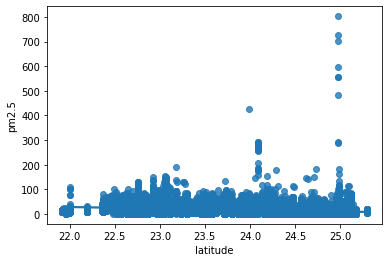

In [22]:
# 緯度跟pm關係
sns.regplot(x = train_new['latitude'], y=train_new['pm2.5'])
plt.show()

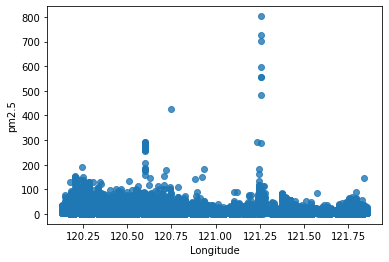

In [23]:
# 經度度跟pm關係
sns.regplot(x = train_new['Longitude'], y=train_new['pm2.5'])
plt.show() 

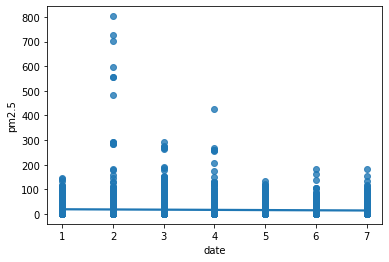

In [24]:
# 日期跟pm關係
sns.regplot(x = train_new['date'], y=train_new['pm2.5'])
plt.show()

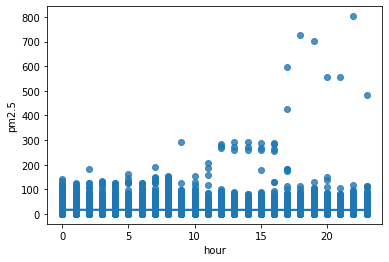

In [25]:
# 小時跟pm關係
sns.regplot(x = train_new['hour'], y=train_new['pm2.5'])
plt.show()

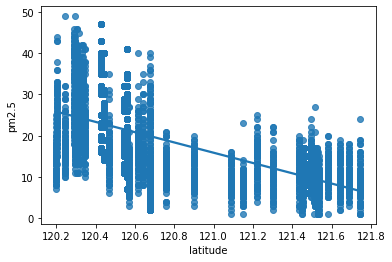

In [93]:
# 調整離群值
keep_indexs = (train_new['pm2.5'] < 50 ) & (train_new['pm2.5'] > 0 )
train_new = train_new[keep_indexs]
sns.regplot(x = train_new['latitude'], y=train_new['pm2.5'])
plt.show()

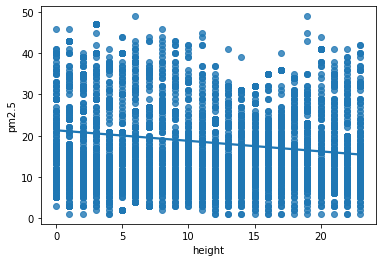

In [94]:
sns.regplot(x = train_new['height'], y=train_new['pm2.5'])
plt.show()

In [108]:
# 切分訓練集/測試集
target = train_new['pm2.5']
train_split = train_new.drop(['pm2.5'], axis=1)
x_train, x_test, y_train, y_test = train_test_split(train_split, target, test_size=0.25, random_state=4)

In [117]:
rf = RandomForestRegressor(n_estimators=300, min_samples_split=9, min_samples_leaf=10, 
                           max_features='sqrt', max_depth=8, bootstrap=False)
gdbt = GradientBoostingRegressor(tol=0.1, subsample=0.37, n_estimators=200, max_features=20, 
        max_depth=6, learning_rate=0.03)
gdbt.fit(train_split, target)
# 使用test資料預測
predictedgdbt=gdbt.predict(test)


In [ ]:
loss = ['ls', 'lad', 'huber']
n_estimators = [300, 500, 600, 800]
max_depth = [2, 3, 5, 10, 15]
min_samples_leaf = [ 6, 8 , 10] 
min_samples_split = [2, 4, 6, 10]
max_features = ['auto', 'sqrt', 'log2', None]

# Define the grid of hyperparameters to search
hyperparameter_grid = {'loss': loss,
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'min_samples_leaf': min_samples_leaf,
    'min_samples_split': min_samples_split,
    'max_features': max_features}

# Set up the random search with 4-fold cross validation
random_cv = RandomizedSearchCV(estimator=gradientboost,
            param_distributions=hyperparameter_grid,
            cv=4, n_iter=50,
            scoring = 'neg_mean_absolute_error',
            verbose = 5, 
            random_state=42)
random_cv.fit(x_train,y_train)

print(random_cv.best_estimator_)
print(random_cv.best_score_)

In [123]:
sub = pd.DataFrame({"id":ids , "pm2.5" :predictedgdbt})
sub.to_csv("728gdbt.csv" , index=False)

In [98]:
aa = gdbt.predict(test)

In [99]:
# from ctypes.wintypes import tagRECT
# import xgboost as xgb

# # 建立 XGBRegressor 模型
# cv_params = {'max_depth': [3, 4, 5, 6, 7, 8, 9, 10], 'min_child_weight': [1, 2, 3, 4, 5, 6]}
# other_params = {'learning_rate': 0.07, 'n_estimators': 650, 'max_depth': 7, 'min_child_weight': 6, 'seed': 0,
#                     'subsample': 0.6, 'colsample_bytree': 0.8, 'gamma': 0.1, 'reg_alpha': 3, 'reg_lambda': 1}
# xgbrModel = xgb.XGBRegressor(**other_params)
# 使用訓練資料訓練模型
# xgbrModel.fit(train_split, target)
# 使用test資料預測
# predicted=xgbrModel.predict(test)
# sub = pd.DataFrame({'id': ids, 'pm2.5': np.round(predicted)})
# sub.to_csv('727.csv', index=False) 

# optimized_GBM = GridSearchCV(estimator=xgbrModel, param_grid=cv_params, scoring='r2', cv=5, verbose=1, n_jobs=4)
# optimized_GBM.fit(x_train, y_train)
# evalute_result = optimized_GBM.cv_results_
# print('每輪结果:{0}'.format(evalute_result))
# print('参数的最佳取值：{0}'.format(optimized_GBM.best_params_))
# print('最佳模型得分:{0}'.format(optimized_GBM.best_score_))

In [118]:
import xgboost as xgb

xgbrModel = xgb.XGBRegressor(learning_rate= 0.1,
n_estimators= 500,
max_depth= 5,
min_child_weight= 1,
subsample= 0.8,
colsample_bytree=0.8,
gamma= 0,
reg_alpha= 0,
reg_lambda= 1)
# 使用訓練資料訓練模型
xgbrModel.fit(train_split, target)
# 使用test資料預測
predictedxg=xgbrModel.predict(test)


In [120]:
sub = pd.DataFrame({"id":ids , "pm2.5" : predictedxg})
sub.to_csv("728xg.csv" , index=False)

In [105]:

print(mean_squared_error(y_test ,np.round( )))

0.1043893679227278


In [107]:
print(predicted)

[2.4939456 3.1245987 2.5641482 ... 2.664926  2.1983273 3.1923714]
